In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head()

(2361, 3)


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
10007,From: jet@netcom.Netcom.COM (J. Eric Townsend)...,8,rec.motorcycles
10008,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,10,rec.sport.hockey
10017,From: nstramer@supergas.dazixco.ingr.com (Naft...,17,talk.politics.mideast
10019,From: mussack@austin.ibm.com (Christopher Muss...,15,soc.religion.christian


In [13]:
# Import Dataset
df = pd.read_json('data/history/refactor.json')
# df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)
df.head()

(32085, 1)


,content
0,Друзья! \n\nВ ближайшие дни на сайте www.proekt.media будет опубликована наша первая большая ист...
1,"Если вы еще не поняли, то Bork просто взяла фрагмент из программы «Центральное телевидение» еще ..."
10,"Арам Габрелянов уходит из СМИ, утверждают источники «Проекта», знакомые с медиаменеджером, и со..."
100,"Этим вечером в рассылке: очередные проблемы IT из-за пакета Яровой, миллионные заработки детей ..."
1000,Новые данные о большом числе погибших и раненых россиян в Сирии и неожиданный выход Сергея Галиц...


In [14]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['друзья', 'ближаишие', 'дни', 'на', 'саите', 'www', 'proekt', 'media', 'будет', 'опубликована', 'наша', 'первая', 'большая', 'история', 'за', 'неи', 'другие', 'эксклюзивные', 'тексты', 'но', 'кроме', 'истории', 'расследовании', 'нас', 'будут', 'эксклюзивные', 'новости', 'их', 'мы', 'будем', 'публиковать', 'только', 'здесь', 'этом', 'канале', 'сегодня', 'первая', 'из', 'них', 'про', 'владимира', 'путина', 'президент', 'россии', 'как', 'выясняется', 'рекламирует', 'компанию', 'bork', 'на', 'рекламных', 'плазмах', 'ее', 'розничных', 'точках', 'крутят', 'вот', 'такои', 'ролик', 'участием', 'путина', 'он', 'же', 'опубликован', 'на', 'их', 'youtube', 'канале', 'странно', 'что', 'никто', 'до', 'сих', 'пор', 'не', 'обратил', 'на', 'это', 'внимание', 'ведь', 'демонстрируют', 'рекламу', 'президентом', 'очень', 'часто', 'по', 'краинеи', 'мере', 'мы', 'обнаружили', 'что', 'ролик', 'показывают', 'примерно', 'каждые', 'минут', 'магазине', 'bork', 'торговом', 'центре', 'метрополис', 'смотрите', 'ег

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!


In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())
#> [(0,
#>   '0.017*"write" + 0.015*"people" + 0.014*"organization" + 0.014*"article" + '
#>   '0.013*"time" + 0.008*"give" + 0.008*"first" + 0.007*"tell" + 0.007*"new" + '
#>   '0.007*"question"'),
#>  (1,
#>   '0.008*"christian" + 0.008*"believe" + 0.007*"god" + 0.007*"law" + '
#>   '0.006*"state" + 0.006*"israel" + 0.006*"israeli" + 0.005*"exist" + '
#>   '0.005*"way" + 0.004*"bible"'),
#>  (2,
#>   '0.024*"armenian" + 0.012*"bike" + 0.006*"kill" + 0.006*"work" + '
#>   '0.005*"well" + 0.005*"year" + 0.005*"sumgait" + 0.005*"soldier" + '
#>   '0.004*"way" + 0.004*"ride"'),
#>  (3,
#>   '0.019*"team" + 0.019*"game" + 0.013*"hockey" + 0.010*"player" + '
#>   '0.009*"play" + 0.009*"win" + 0.009*"nhl" + 0.009*"year" + 0.009*"hawk" + '
#>   '0.009*"season"')]

[(0,
  '0.029*"для" + 0.028*"года" + 0.016*"через" + 0.010*"чем" + 0.010*"сша" + '
  '0.009*"ворот" + 0.007*"москве" + 0.006*"хорватия" + 0.006*"выход" + '
  '0.006*"стоит"'),
 (1,
  '0.020*"сеичас" + 0.011*"может" + 0.010*"году" + 0.009*"наши" + 0.009*"far" '
  '+ 0.008*"рассказал" + 0.008*"people_vote" + 0.006*"что" + 0.006*"месте" + '
  '0.006*"территории"'),
 (2,
  '0.024*"было" + 0.009*"по" + 0.008*"почти" + 0.008*"можно" + 0.007*"трампа" '
  '+ 0.007*"против" + 0.006*"очень" + 0.006*"канал" + 0.005*"россия" + '
  '0.005*"требует"'),
 (3,
  '0.063*"на" + 0.053*"россии" + 0.034*"не" + 0.009*"но" + 0.008*"команда" + '
  '0.007*"акинфеев" + 0.006*"это" + 0.006*"заявил" + 0.006*"об_этом" + '
  '0.006*"после"')]


In [17]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.4986,"на, россии, не, но, команда, акинфеев, это, заявил, об_этом, после","[medium, на, путина, странно, не, обратил, это, внимание, обнаружили, watch]"
1,1,3.0,0.7958,"на, россии, не, но, команда, акинфеев, это, заявил, об_этом, после","[фрагмент, этот, путина]"
2,2,0.0,0.4545,"для, года, через, чем, сша, ворот, москве, хорватия, выход, стоит","[длительныи, конфликт, кремлевскои, администрации, лишился, заместителем, больше, является, конт..."
3,3,0.0,0.2500,"для, года, через, чем, сша, ворот, москве, хорватия, выход, стоит",[]
4,4,1.0,0.4170,"сеичас, может, году, наши, far, рассказал, people_vote, что, месте, территории","[числе, погибших, раненых, сирии, неожиданныи, выход]"
5,5,3.0,0.4169,"на, россии, не, но, команда, акинфеев, это, заявил, об_этом, после","[сегодня, на]"
6,6,1.0,0.7042,"сеичас, может, году, наши, far, рассказал, people_vote, что, месте, территории","[налысо, поражение]"
7,7,2.0,0.7171,"было, по, почти, можно, трампа, против, очень, канал, россия, требует","[впереди, было]"
8,8,0.0,0.2500,"для, года, через, чем, сша, ворот, москве, хорватия, выход, стоит",[]
9,9,1.0,0.6250,"сеичас, может, году, наши, far, рассказал, people_vote, что, месте, территории",[выхода]


In [18]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9467,"для, года, через, чем, сша, ворот, москве, хорватия, выход, стоит","[авиакомпании, наручники, для, летом, года, аэрофлот, появилось, больше, основании, через, суд, ..."
1,1.0,0.9266,"сеичас, может, году, наши, far, рассказал, people_vote, что, месте, территории","[проходили, либо, средствами, передаче, очередных, отступных, http, veve, ru_press, siloviki, iz..."
2,2.0,0.9460,"было, по, почти, можно, трампа, против, очень, канал, россия, требует","[было, гостиничныи, номер, uhprw, похоронил, своего, было, позже, avtznv, грязь, выпуск, передач..."
3,3.0,0.9589,"на, россии, не, но, команда, акинфеев, это, заявил, об_этом, после","[вдруг, просто, выпускать, не, выживут, на, оставшееся, на, выпускать, лоббисты, тименко, шумныи..."


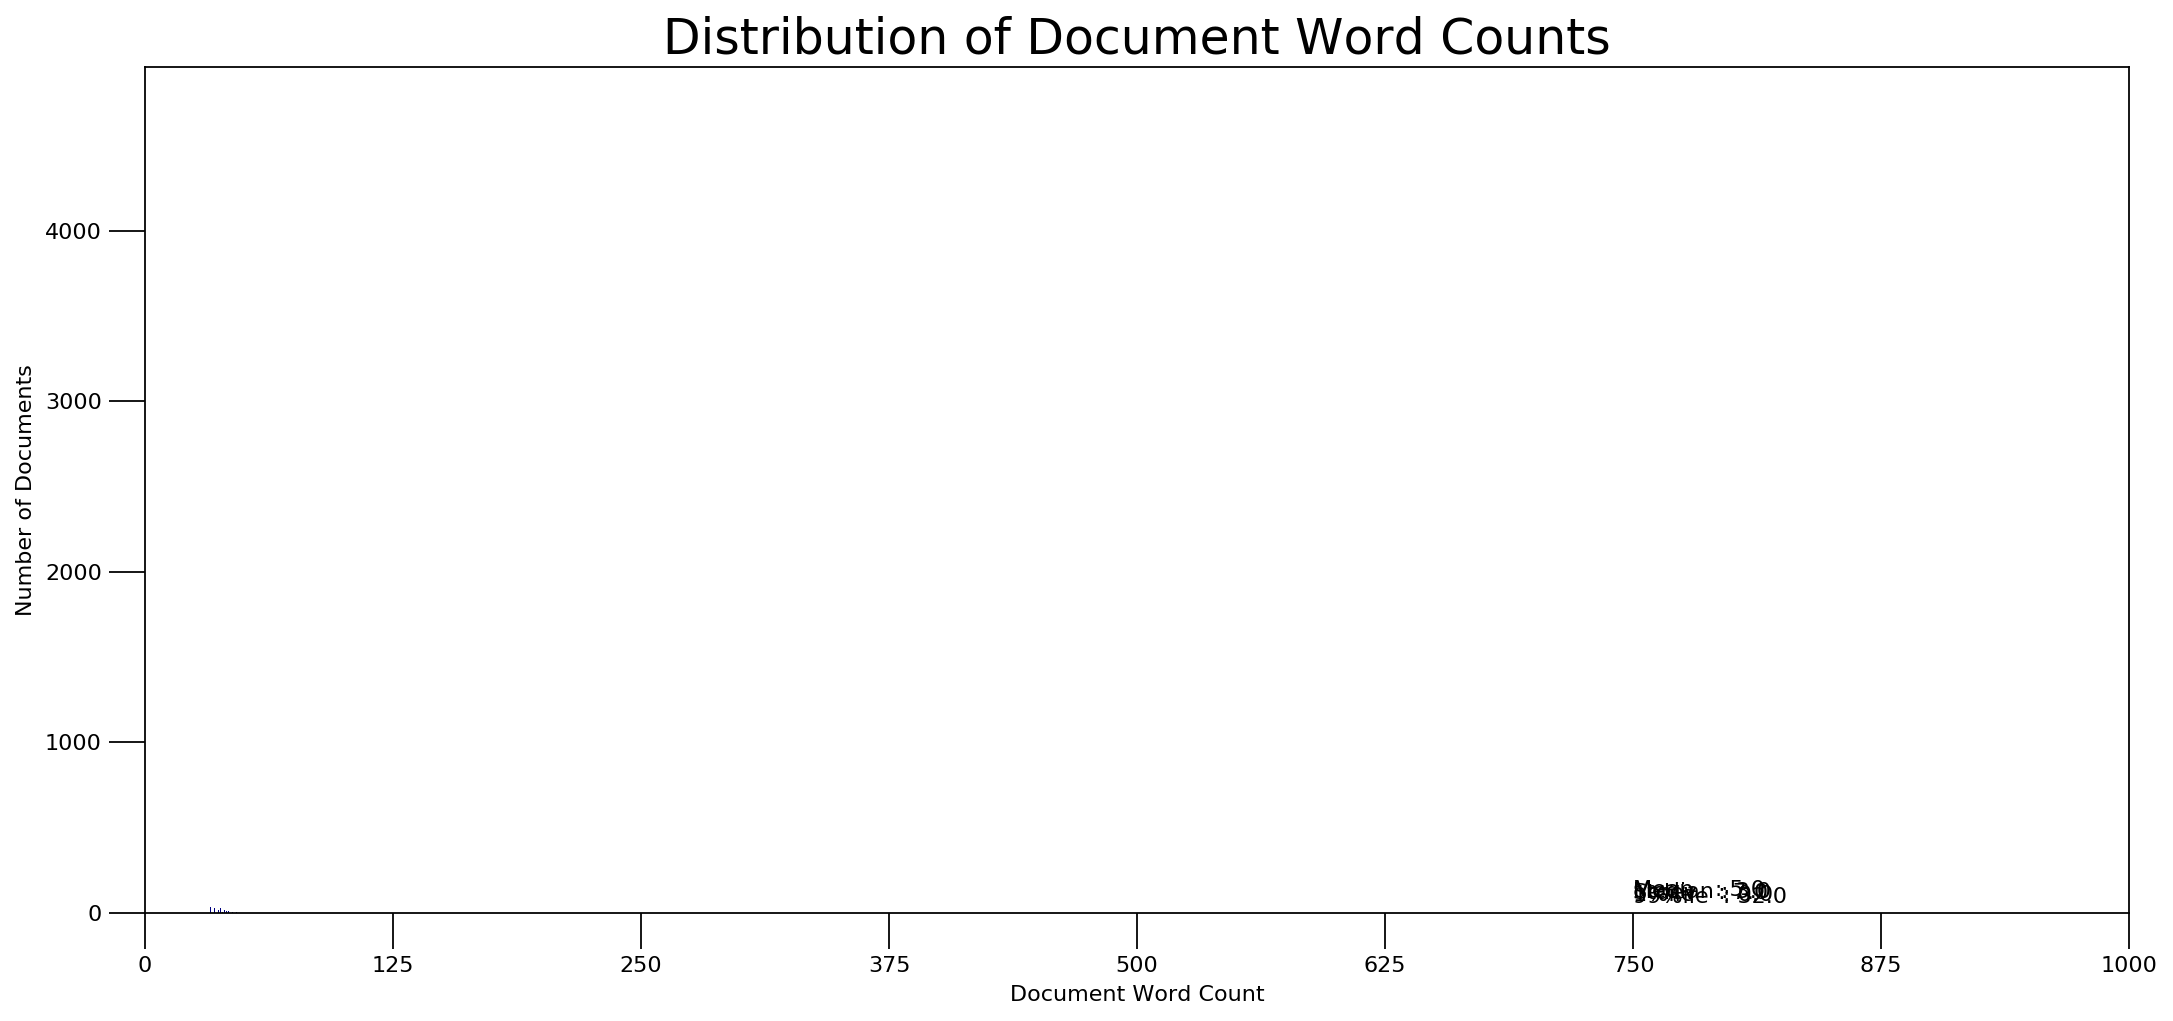

In [19]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

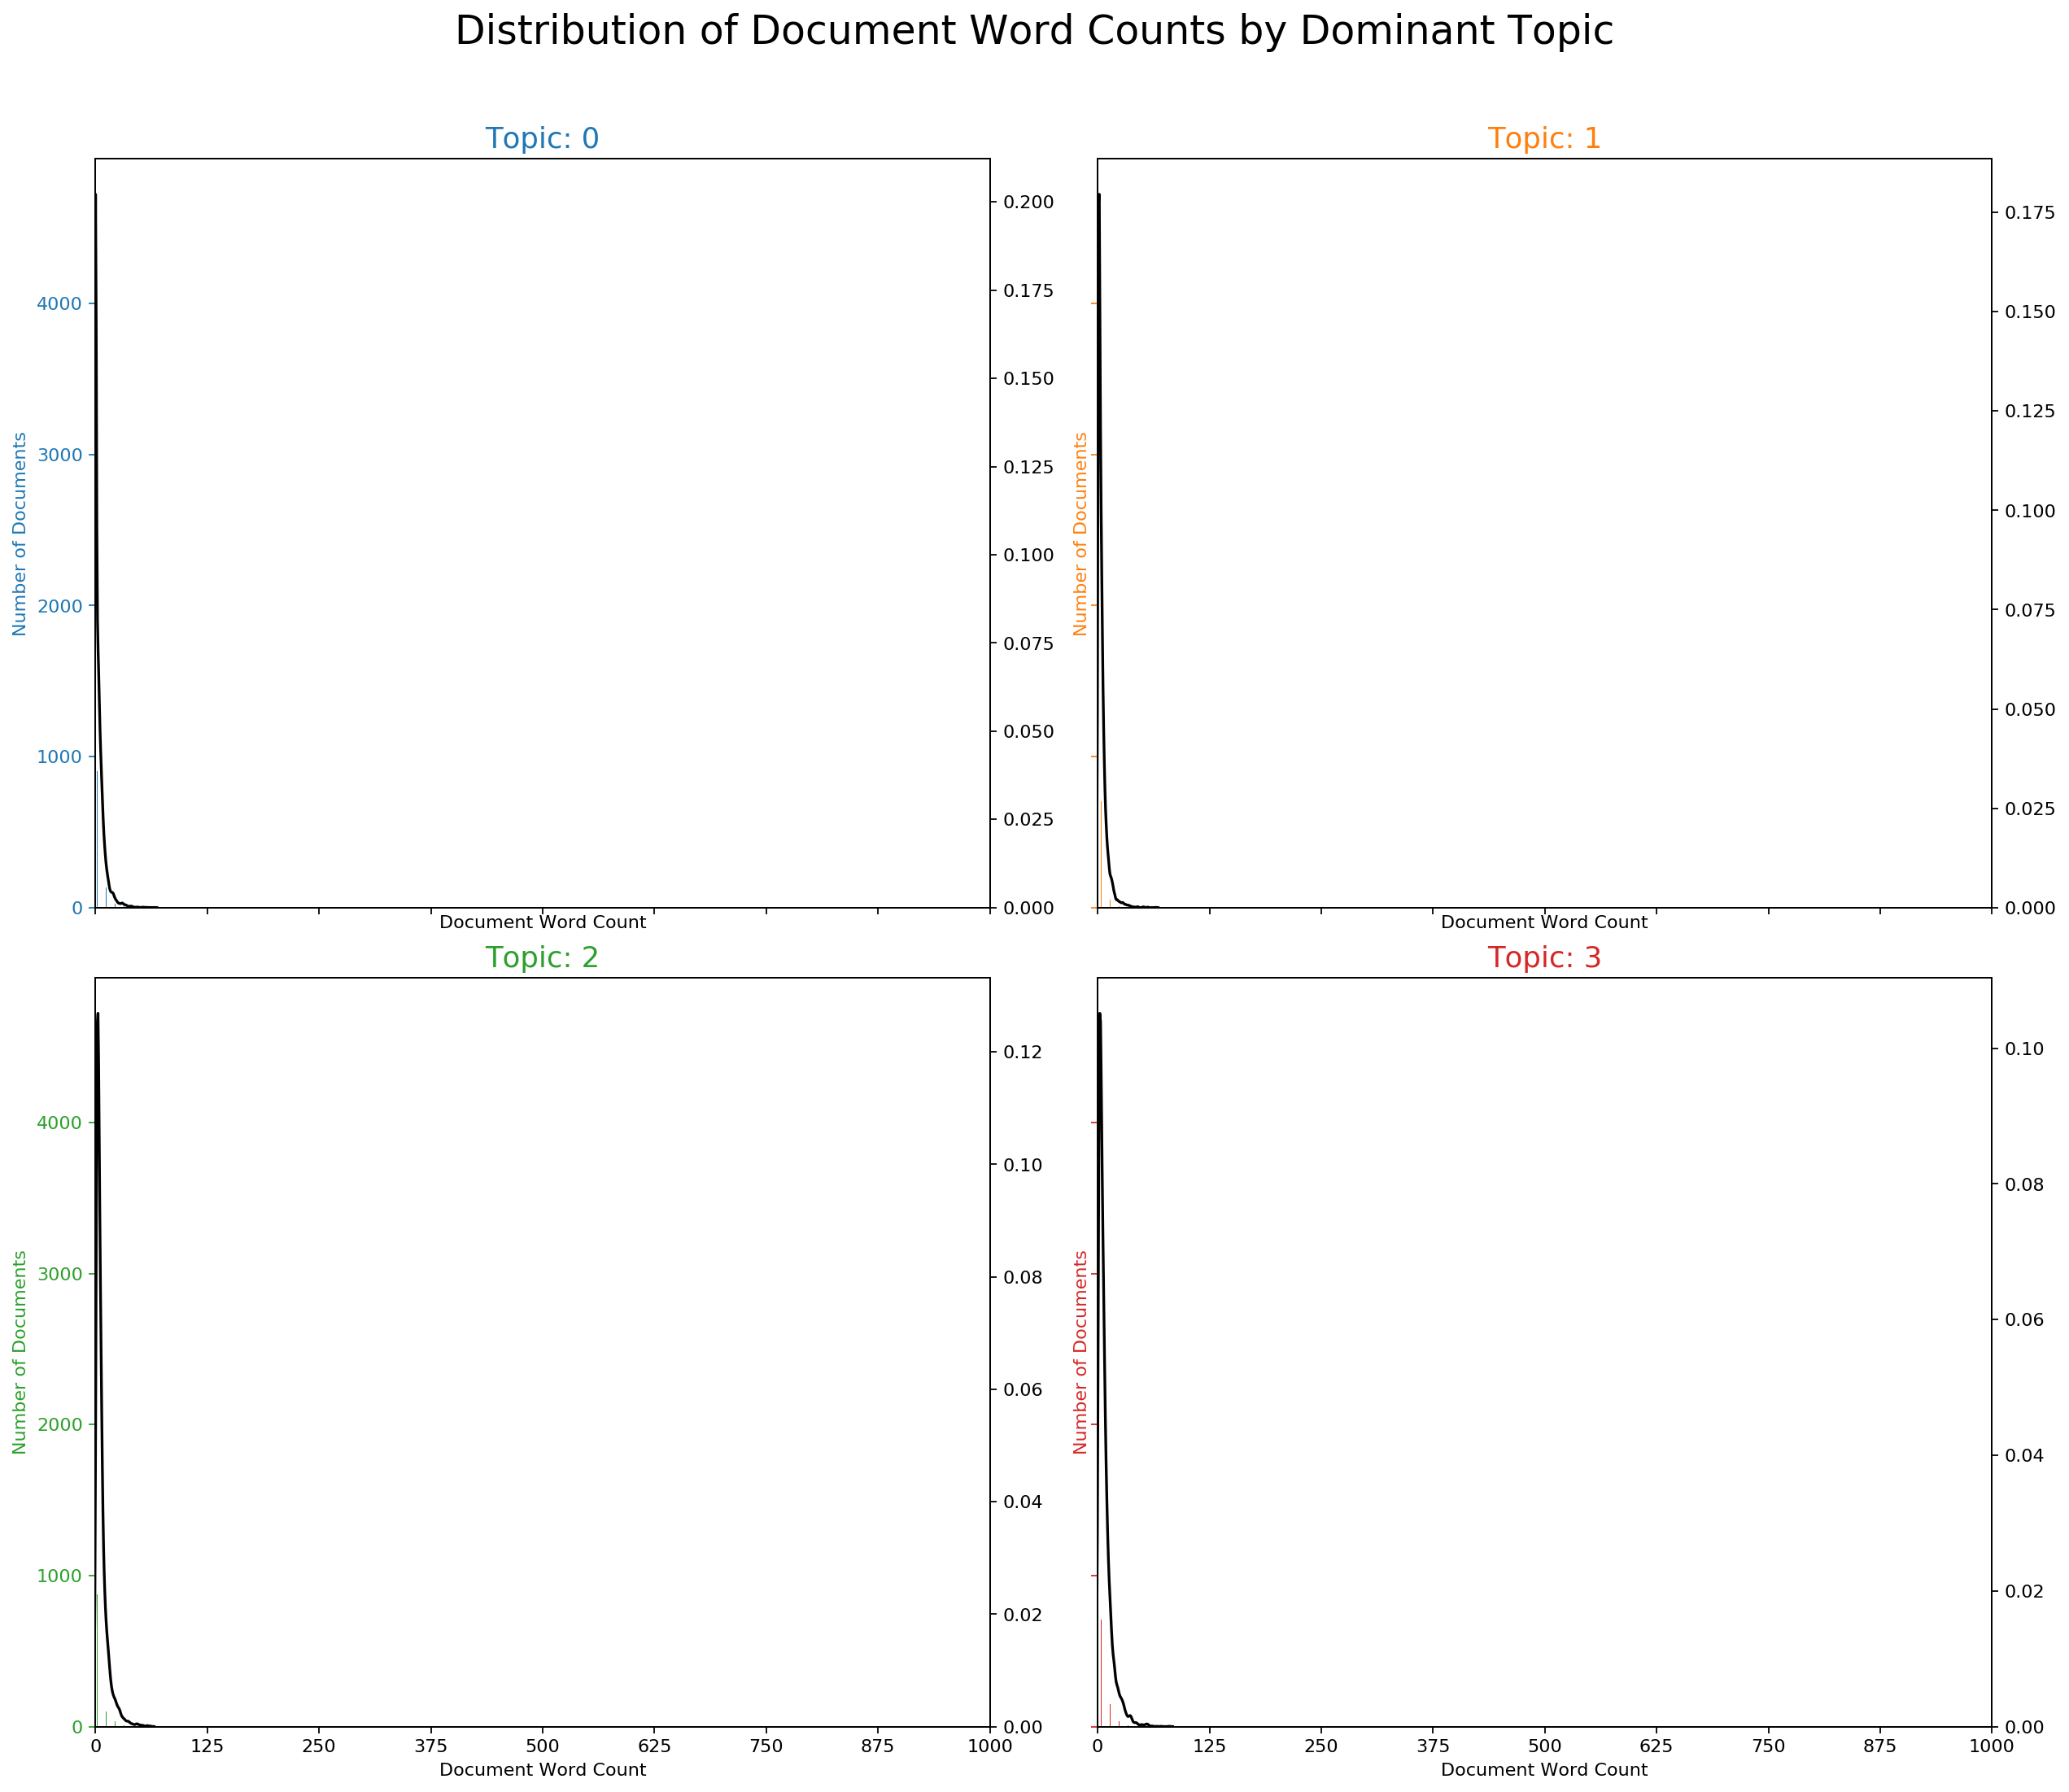

In [20]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

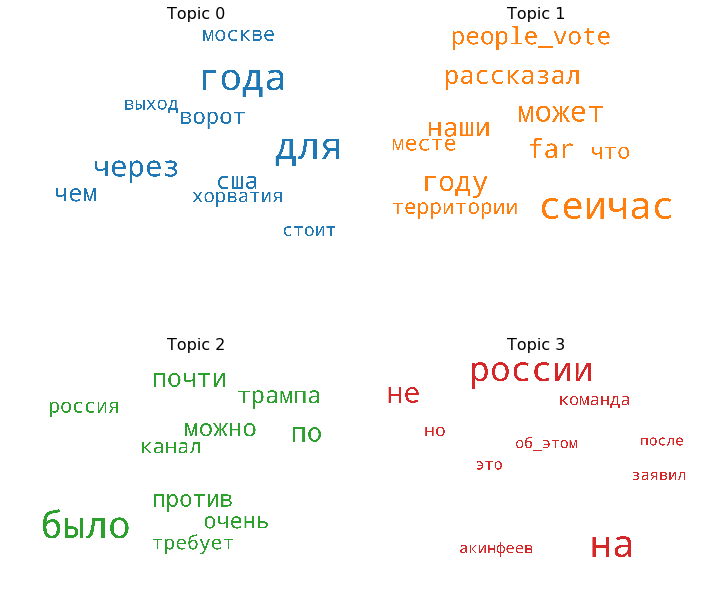

In [21]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()